# Анализ влияния близости школ на пешеходный трафик и средний чек

Цель: сравнить **пешеходный трафик** и средний чек магазинов, которые находятся **рядом со школой** (есть школы в радиусе 300 м) и **не рядом со школой**, при фиксированных остальных условиях.

Работаем с файлом:
- `Х5_with_region_index_2024_population_patched_with_flags.xlsx`

Используемые поля:
- `Населенный пункт`
- `Регион`
- `Школы (300 м)` — количество школ в радиусе 300 м
- `Трафик пеший, в час` — пешеходный трафик магазина
- `Средний чек`
- `Торговая площадь, категориальный` — размер магазина ("Маленький", "Средний", "Большой", "Очень большой")
- `Индекс_РИА_2024` — индекс развития территории
- `is_season` — флаг сезонности (1 — учебный сезон)
- `traffic_flag` — флаг корректности/достоверности трафика (1 — данные ок)

## Логика расчёта

1. **Фильтруем по индексу развития**: берём только строки, где `30 < Индекс_РИА_2024 < 70`.
2. **Фильтруем по сезонности и качеству трафика**:
   - `is_season == 1` (учебное время, не лето);
   - `traffic_flag == 1`.
3. **Фильтруем по пешеходному трафику**: оставляем только магазины, где
   - `Трафик пеший, в час > 0`.
   
   Автомобильный трафик **полностью игнорируем**: ни как фильтр, ни как метрику.

4. **Классифицируем магазины по размеру** по полю `Торговая площадь, категориальный`:
   - `Маленький` → группа `small`;
   - `Средний` → группа `medium`;
   - `Большой` и `Очень большой` → группа `large_plus`.
5. **Формируем признак наличия школы**:
   - `has_school = (Школы (300 м) > 0)`.
6. Для **каждого населённого пункта и региона** отдельно:
   - делим магазины на две группы:
     - рядом со школой (`has_school = True`),
     - не рядом со школой (`has_school = False`);
   - и внутри каждой группы считаем по размеру магазина (`small`, `medium`, `large_plus`):
     - средний **пешеходный** трафик (`mean(Трафик пеший, в час)`),
     - средний чек (`mean(Средний чек)`).
7. Для каждой комбинации (НП, регион, размер) считаем **отношения**:
   - `traffic_ratio_* = mean_ped_traffic(есть школа) / mean_ped_traffic(нет школы)`;
   - `check_ratio_* = mean_check(есть школа) / mean_check(нет школы)`.
8. Собираем финальную таблицу:
   - `Населенный пункт`, `Регион`,
   - 6 чисел:
     - `traffic_ratio_small`, `check_ratio_small`,
     - `traffic_ratio_medium`, `check_ratio_medium`,
     - `traffic_ratio_large_plus`, `check_ratio_large_plus`.


In [1]:
import pandas as pd
from pathlib import Path

# Путь к исходному файлу 
input_path = Path("Х5_with_region_index_2024_population_patched_with_flags.xlsx")

# Загрузка данных
df = pd.read_excel(input_path)

print("Размер исходного датафрейма:", df.shape)
print("\nПервые 10 столбцов:")
print(df.columns[:10].tolist())

df.head()

Размер исходного датафрейма: (256711, 21)

Первые 10 столбцов:
['new_id', 'Месяц', 'Трафик', 'Средний чек', 'Дата открытия, категориальный', 'Торговая площадь, категориальный', 'Населенный пункт', 'Регион', 'Численность населения', 'Количество домохозяйств']


,new_id,Месяц,Трафик,Средний чек,"Дата открытия, категориальный","Торговая площадь, категориальный",Населенный пункт,Регион,Численность населения,Количество домохозяйств,...,"Трафик авто, в час","Маркетплейсы, доставки, постаматы (100 м)",Медицинские уч. и аптеки (300 м),Школы (300 м),Остановки (300 м),Продуктовые магазины (500 м),Пятерочки (500 м),Индекс_РИА_2024,traffic_flag,is_season
0,0,10,59662,976.170936,Средний по возрасту,Средний,Абинск г,Краснодарский край,38231,728,...,146.4,0,0,0,0,0,0,76.58,1,0
1,0,5,56674,1025.462154,Средний по возрасту,Средний,Абинск г,Краснодарский край,38231,728,...,146.4,0,0,0,0,0,0,76.58,1,0
2,0,1,51488,1158.150890,Средний по возрасту,Средний,Абинск г,Краснодарский край,38231,728,...,146.4,0,0,0,0,0,0,76.58,1,0
3,3594,7,68039,1119.028697,Средний по возрасту,Средний,"1-го отделения совхоза ""Масловский"" п",Воронежская обл,3827,768,...,406.0,5,1,0,0,1,0,61.98,1,1
4,3594,6,64878,1112.584778,Средний по возрасту,Средний,"1-го отделения совхоза ""Масловский"" п",Воронежская обл,3827,768,...,406.0,5,1,0,0,1,0,61.98,1,1


<Axes: xlabel='Индекс_РИА_2024', ylabel='count'>

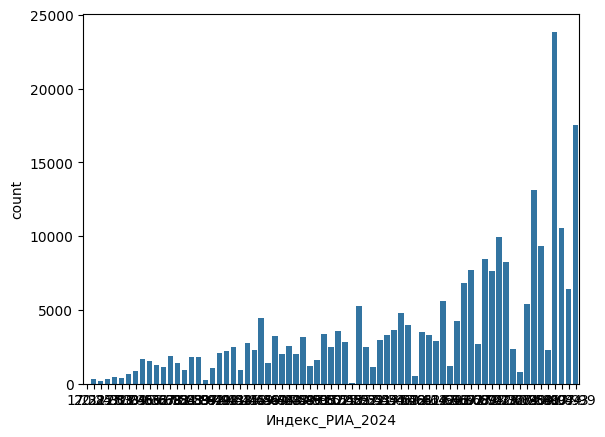

In [3]:
import seaborn as sns

sns.countplot(data=df, x="Индекс_РИА_2024")

## Шаг 1. Фильтрация по индексу развития, сезонности и качеству трафика

- Оставляем только строки, где `30 < Индекс_РИА_2024 < 70`.
- Берём только `is_season == 1` (учебное время).
- Берём только `traffic_flag == 1`.
- Фильтруем по ненулевому **пешеходному** трафику.
- Автомобильный трафик не используем.


In [ ]:
# Названия ключевых столбцов
col_index = "Индекс_РИА_2024"
col_is_season = "is_season"
col_traffic_flag = "traffic_flag"
col_pedestrian = "Трафик пеший, в час"

# Приводим индекс к числу на всякий случай
df[col_index] = pd.to_numeric(df[col_index], errors="coerce")

# Фильтры по условиям
mask_index = (df[col_index] > 70)
mask_season = df[col_is_season] == 1
mask_traffic_flag = df[col_traffic_flag] == 1
mask_pedestrian = df[col_pedestrian] > 0

# Автотрафик теперь не учитываем ни в фильтре, ни в метриках
base_df = df[mask_index & mask_season & mask_traffic_flag & mask_pedestrian].copy()

print("Размер после фильтрации:", base_df.shape)
base_df.head()

Размер после фильтрации: (36896, 21)


,new_id,Месяц,Трафик,Средний чек,"Дата открытия, категориальный","Торговая площадь, категориальный",Населенный пункт,Регион,Численность населения,Количество домохозяйств,...,"Трафик авто, в час","Маркетплейсы, доставки, постаматы (100 м)",Медицинские уч. и аптеки (300 м),Школы (300 м),Остановки (300 м),Продуктовые магазины (500 м),Пятерочки (500 м),Индекс_РИА_2024,traffic_flag,is_season
3,3594,7,68039,1119.028697,Средний по возрасту,Средний,"1-го отделения совхоза ""Масловский"" п",Воронежская обл,3827,768,...,406.0,5,1,0,0,1,0,61.98,1,1
4,3594,6,64878,1112.584778,Средний по возрасту,Средний,"1-го отделения совхоза ""Масловский"" п",Воронежская обл,3827,768,...,406.0,5,1,0,0,1,0,61.98,1,1
10,3594,8,74160,1275.068118,Средний по возрасту,Средний,"1-го отделения совхоза ""Масловский"" п",Воронежская обл,3827,768,...,406.0,5,1,0,0,1,0,61.98,1,1
13,8781,7,40386,683.123700,Средний по возрасту,Средний,1-я Моква д,Курская обл,500,201,...,483.2,0,0,1,0,1,1,50.02,1,1
15,8781,8,39323,687.641711,Средний по возрасту,Средний,1-я Моква д,Курская обл,500,201,...,483.2,0,0,1,0,1,1,50.02,1,1


## Шаг 2. Признак наличия школы и группы по размеру магазина

1. Формируем флаг `has_school`:
   - `True`, если `Школы (300 м) > 0`;
   - `False`, если `Школы (300 м) == 0`.
2. Переводим `Торговая площадь, категориальный` в три группы:
   - `Маленький` → `small`;
   - `Средний` → `medium`;
   - `Большой` и `Очень большой` → `large_plus`.


In [ ]:
col_schools = "Школы (300 м)"
col_size_cat = "Торговая площадь, категориальный"

# Признак наличия школ
base_df[col_schools] = pd.to_numeric(base_df[col_schools], errors="coerce").fillna(0)
base_df["has_school"] = base_df[col_schools] > 0

# Маппинг категорий площади в 3 группы
size_map = {
    "Маленький": "small",
    "Средний": "medium",
    "Большой": "large_plus",
    "Очень большой": "large_plus",
}

base_df["size_group"] = base_df[col_size_cat].map(size_map)

# Оставляем только строки с валидными size_group
base_df = base_df[base_df["size_group"].notna()].copy()

print("Размер после добавления признаков и фильтрации по size_group:", base_df.shape)
base_df[["Населенный пункт", "Регион", col_size_cat, "size_group", col_schools, "has_school"]].head()

Размер после добавления признаков и фильтрации по size_group: (36896, 23)


,Населенный пункт,Регион,"Торговая площадь, категориальный",size_group,Школы (300 м),has_school
3,"1-го отделения совхоза ""Масловский"" п",Воронежская обл,Средний,medium,0,False
4,"1-го отделения совхоза ""Масловский"" п",Воронежская обл,Средний,medium,0,False
10,"1-го отделения совхоза ""Масловский"" п",Воронежская обл,Средний,medium,0,False
13,1-я Моква д,Курская обл,Средний,medium,1,True
15,1-я Моква д,Курская обл,Средний,medium,1,True


## Шаг 3. Расчёт средних значений по группам (школа / нет школы, размер)

- Для каждого сочетания:
  - `Населенный пункт`,
  - `Регион`,
  - `size_group`,
  - `has_school` (есть / нет школ рядом)
  
считаем:
- средний **пешеходный** трафик (`mean(Трафик пеший, в час)`),
- средний чек (`mean(Средний чек)`).


In [ ]:
col_np = "Населенный пункт"
col_region = "Регион"
col_traffic = col_pedestrian  # Используем только пешеходный трафик
col_check = "Средний чек"

# На всякий случай приводим метрики к числам
base_df[col_traffic] = pd.to_numeric(base_df[col_traffic], errors="coerce")
base_df[col_check] = pd.to_numeric(base_df[col_check], errors="coerce")

group_cols = [col_np, col_region, "size_group", "has_school"]

agg_df = (
    base_df
    .groupby(group_cols)
    .agg(
        mean_traffic=(col_traffic, "mean"),
        mean_check=(col_check, "mean"),
        count=(col_traffic, "size"),
        
    )
    .reset_index()
)

print("Размер агрегированного датафрейма:", agg_df.shape)
agg_df.head()

Размер агрегированного датафрейма: (3777, 7)


,Населенный пункт,Регион,size_group,has_school,mean_traffic,mean_check,count
0,"1-го отделения совхоза ""Масловский"" п",Воронежская обл,medium,False,89.857143,1168.893864,3
1,1-я Моква д,Курская обл,medium,False,86.555556,1344.300361,3
2,1-я Моква д,Курская обл,medium,True,95.666667,670.241819,3
3,Абадзехская ст-ца,Адыгея Респ,small,False,71.666667,833.505861,3
4,Абаза г,Хакасия Респ,medium,False,321.846154,844.179205,3


## Шаг 4. Расчёт отношений (есть школа / нет школы) по каждой группе размера

Для каждого населённого пункта и размера (`small`, `medium`, `large_plus`):

- считаем:
  - `traffic_ratio_* = mean_ped_traffic(есть школа) / mean_ped_traffic(нет школы)`;
  - `check_ratio_* = mean_check(есть школа) / mean_check(нет школы)`.

Если для какой-то комбинации нет данных либо для магазинов со школами, либо без школ, отношение будет `NaN`.


In [5]:
records = []

for (np_name, region_name, size_group), sub in agg_df.groupby([col_np, col_region, "size_group"]):
    # Разделяем на магазины рядом со школой и без школы
    with_school = sub[sub["has_school"] == True]
    without_school = sub[sub["has_school"] == False]

    if with_school.empty or without_school.empty:
        # Если одной из групп нет, пропускаем или пишем NaN
        traffic_ratio = float("nan")
        check_ratio = float("nan")
    else:
        mean_traf_school = with_school["mean_traffic"].iloc[0]
        mean_traf_no_school = without_school["mean_traffic"].iloc[0]
        mean_check_school = with_school["mean_check"].iloc[0]
        mean_check_no_school = without_school["mean_check"].iloc[0]

        traffic_ratio = mean_traf_school / mean_traf_no_school if mean_traf_no_school != 0 else float("nan")
        check_ratio = mean_check_school / mean_check_no_school if mean_check_no_school != 0 else float("nan")

    records.append(
        {
            col_np: np_name,
            col_region: region_name,
            "size_group": size_group,
            "traffic_ratio": traffic_ratio,
            "check_ratio": check_ratio,
        }
    )

ratio_df = pd.DataFrame(records)

print("Размер датафрейма с отношениями:", ratio_df.shape)
ratio_df.head()

Размер датафрейма с отношениями: (3037, 5)


,Населенный пункт,Регион,size_group,traffic_ratio,check_ratio
0,"1-го отделения совхоза ""Масловский"" п",Воронежская обл,medium,NaN,NaN
1,1-я Моква д,Курская обл,medium,1.105263,0.49858
2,Абадзехская ст-ца,Адыгея Респ,small,NaN,NaN
3,Абаза г,Хакасия Респ,medium,NaN,NaN
4,Абакан г,Хакасия Респ,large_plus,1.066131,1.00619


## Шаг 5. Поворот таблицы в формат "6 чисел на НП" и сохранение результата

Получаем по строке на каждую пару `(Населенный пункт, Регион)` и 6 столбцов:

- `traffic_ratio_small`, `check_ratio_small`;
- `traffic_ratio_medium`, `check_ratio_medium`;
- `traffic_ratio_large_plus`, `check_ratio_large_plus`.


In [6]:
# Пивот по size_group и типу метрики
pivot = ratio_df.pivot_table(
    index=[col_np, col_region],
    columns="size_group",
    values=["traffic_ratio", "check_ratio"],
)

# Преобразуем мультииндекс столбцов в плоский
pivot.columns = [f"{metric}_{size}" for metric, size in pivot.columns]
pivot = pivot.reset_index()

# На всякий случай сортируем по региону и НП
pivot = pivot.sort_values([col_region, col_np]).reset_index(drop=True)

print("Финальная таблица (первые строки):")
pivot.head()

Финальная таблица (первые строки):


,Населенный пункт,Регион,check_ratio_large_plus,check_ratio_medium,check_ratio_small,traffic_ratio_large_plus,traffic_ratio_medium,traffic_ratio_small
0,Майкоп г,Адыгея Респ,NaN,1.019576,1.051715,NaN,0.918438,0.698583
1,Тахтамукай аул,Адыгея Респ,NaN,1.080329,NaN,NaN,1.435785,NaN
2,Энем пгт,Адыгея Респ,NaN,0.799786,NaN,NaN,0.385974,NaN
3,Яблоновский пгт,Адыгея Респ,NaN,0.849199,NaN,NaN,0.235805,NaN
4,Барнаул г,Алтайский край,1.131623,0.988751,0.884846,1.062328,0.996061,1.230678


In [7]:
# Сохранение результата
output_excel = Path("ri_school_ped_traffic_check_ratios_by_np.xlsx")


pivot.to_excel(output_excel, index=False)


print("Сохранены файлы:")
print("Excel:", output_excel.resolve())


Сохранены файлы:
Excel: /home/kali_person/Загрузки/Проектный тур Дано/.venv/ri_school_ped_traffic_check_ratios_by_np.xlsx
